In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

In [3]:
names = open("names.txt", "r").read().split()
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [11]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(names))))
charToInt = {s:i+1 for i, s in enumerate(chars)}
charToInt['.'] = 0

intToChar = {i:s for s, i in charToInt.items()}

print(f"{chars}\n\n{charToInt}\n\n{intToChar}")

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [55]:
# build the dataset

block_size = 3
X, Y = [], []

for name in names:
    context = [0] * block_size
    
    for char in name + '.':
        index = charToInt[char]
        X.append(context)
        Y.append(index)
        context = context[1:] + [index]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

# X is inputs, Y is outputs
X, Y

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5,  2],
         ...,
         [18,  5, 12],
         [ 5, 12,  9],
         [12,  9,  1]]),
 tensor([ 5,  2, 18,  ...,  9,  1,  0]))

In [56]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [68]:
# Construct the network

g = torch.Generator().manual_seed(3528942) # for reproducibility
embedMatrix = torch.randn((27, 2))
layer1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
layer2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [embedMatrix, layer1, b1, layer2, b2]

In [69]:
sum(p.nelement() for p in parameters)

3481

In [70]:
for p in parameters:
    p.requires_grad = True

In [71]:
for _ in range(30000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = embedMatrix[X[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, 6) @ layer1 + b1) # -1 in the view means emb.shape(0)
    logits = h @ layer2 + b2
    negLossLikelihood = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    negLossLikelihood.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad
        
print(negLossLikelihood.item())

2.577638864517212


### The above network is okay, but it can be improved by decaying the learning rate. Let us discern what might be a good range/value to decay by.

In [72]:
# Creating values for visualising the learning rate

learnRatesExp = torch.linspace(-3, -0.05, 1000)
learnRates = 10**learnRatesExp

In [73]:
lrs = []
lri = []

In [74]:
for i in range(1000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = embedMatrix[X[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, 6) @ layer1 + b1) # -1 in the view means emb.shape(0)
    logits = h @ layer2 + b2
    negLossLikelihood = F.cross_entropy(logits, Y[ix])
    
    lrs.append(negLossLikelihood.item())
    lri.append(-learnRates[i])
    
    # backward pass
    for p in parameters:
        p.grad = None
    negLossLikelihood.backward()

    # update
    for p in parameters:
        p.data += -learnRates[i] * p.grad
        
print(negLossLikelihood.item())

5.565164566040039


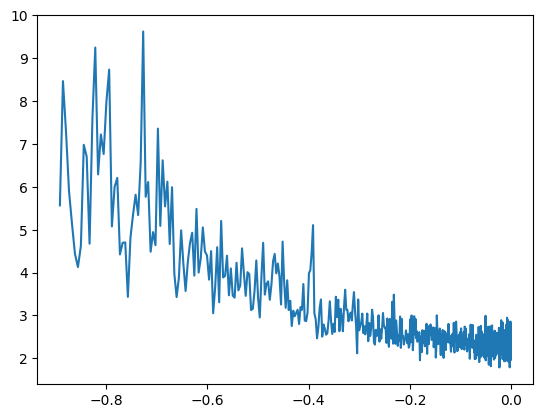

In [75]:
plt.plot(lri, lrs)

### From the above graph, we can see that a learning rate of about -0.1/-0.15 is optimal (we were right first time). It is then from this value that we have the option to decay - I am not going to, however.

In [76]:
# Construct the network

g = torch.Generator().manual_seed(3528942) # for reproducibility
embedMatrix = torch.randn((27, 2))
layer1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
layer2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [embedMatrix, layer1, b1, layer2, b2]

In [78]:
for p in parameters:
    p.requires_grad = True

In [79]:
learnRate = 0.1

for _ in range(30000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = embedMatrix[X[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, 6) @ layer1 + b1) # -1 in the view means emb.shape(0)
    logits = h @ layer2 + b2
    negLossLikelihood = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    negLossLikelihood.backward()

    # update
    for p in parameters:
        p.data += -learnRate * p.grad
        
print(negLossLikelihood.item())

2.348081111907959


### This is a better value. Now, I am going to look to split the data up into training, hyperparameter training, and testing (80%/10%/10% respectively).

In [80]:
def build_dataset(names):
    block_size = 3
    X, Y = [], []
    for name in names:
        context = [0] * block_size

        for char in name + '.':
            index = charToInt[char]
            X.append(context)
            Y.append(index)
            context = context[1:] + [index]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(names)

n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtrain, Ytrain = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[:n2])
Xtest, Ytest = build_dataset(names[n2:])

Xtrain, Ytrain

(tensor([[ 0,  0,  0],
         [ 0,  0, 20],
         [ 0, 20,  1],
         ...,
         [25,  5, 14],
         [ 5, 14, 14],
         [14, 14,  1]]),
 tensor([20,  1, 21,  ..., 14,  1,  0]))

### Now, we take the same network model from before, but train it on the xtrain dataset.

In [81]:
g = torch.Generator().manual_seed(3528942) # for reproducibility
embedMatrix = torch.randn((27, 2))
layer1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
layer2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [embedMatrix, layer1, b1, layer2, b2]

In [82]:
for p in parameters:
    p.requires_grad = True

In [83]:
learnRate = 0.1

for _ in range(30000):
    
    # minibatch construct
    ix = torch.randint(0, Xtrain.shape[0], (32,))
    
    # forward pass
    emb = embedMatrix[Xtrain[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, 6) @ layer1 + b1) # -1 in the view means emb.shape(0)
    logits = h @ layer2 + b2
    negLossLikelihood = F.cross_entropy(logits, Ytrain[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    negLossLikelihood.backward()

    # update
    for p in parameters:
        p.data += -learnRate * p.grad
        
print(negLossLikelihood.item())

2.4156508445739746


In [84]:
emb = embedMatrix[Xdev]
h = torch.tanh(emb.view(-1, 6) @ layer1 + b1)
logits = h @ layer2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.4185893535614014

### From the fact that the loss value for the training and the development datasets are very similar, we can tell that we are *underfitting* this network; it is not yet powerful enough to overfit.
 
### What this typically means, is that the network - currently 3481 parameters - is simply too small.
 
### We can thus add more parameters to the network, and be quite confident that this will improve the performance of it instantly. 

In [85]:
# Changing middle layer length from 100 to 300

g = torch.Generator().manual_seed(3528942) # for reproducibility
embedMatrix = torch.randn((27, 2))
layer1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
layer2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [embedMatrix, layer1, b1, layer2, b2]

In [86]:
for p in parameters:
    p.requires_grad = True

In [88]:
learnRate = 0.1
for _ in range(30000):
    
    # minibatch construct
    ix = torch.randint(0, Xtrain.shape[0], (32,))
    
    # forward pass
    emb = embedMatrix[Xtrain[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, 6) @ layer1 + b1)
    logits = h @ layer2 + b2
    negLossLikelihood = F.cross_entropy(logits, Ytrain[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    negLossLikelihood.backward()

    # update
    for p in parameters:
        p.data += -learnRate * p.grad
        
print(negLossLikelihood.item())

1.9615817070007324


### This shows that increasing the model size lead to a direct improvement in the loss rate.

### We can visualise the networks representation of the letters: the vowels are clustered together, and v, r, q and y seem to be less important as they are farther away from the action.

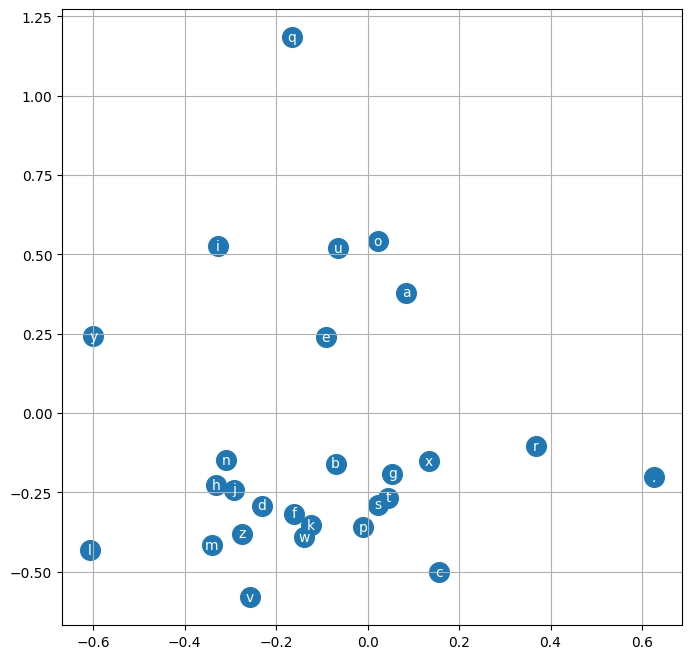

In [89]:
plt.figure(figsize=(8,8))
plt.scatter(embedMatrix[:,0].data, embedMatrix[:,1].data, s=200)
for i in range(embedMatrix.shape[0]):
    plt.text(embedMatrix[i,0].item(), embedMatrix[i,1].item(), intToChar[i], ha="center", va="center", color="white")
plt.grid('minor')

### Next step would be to rearrange the code into objects, as there is a lot of redundant, repeating code here. But this is nice as a first attempt.